In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
from tqdm import tqdm

In [2]:
params = np.load('Datos T2/Params_ecl.npz')
data = np.genfromtxt('Datos T2/ecl.dat',
                     skip_footer=0,
                     names=True,
                     dtype=float,
                     delimiter=' ',
                     encoding='utf-8')

pi_1, pi_2 = params['weights_0']

cov_1, cov_2 = params['covs_0'] # Relacionan a0, b0 y f

pi_3, pi_4 = params['weights_1']

cov_3, cov_4 = params['covs_1']


inicial = [np.mean(data['a0']), np.mean(data['b0']), np.mean(data['a1']), np.mean(data['b1']), np.mean(data['f'])]


### Funciones de likelihood

A continuacion se definen las dos funciones P* usadas en metropolis hastings, estas dependen de todos los datos que vienen en los archivos, y los parametros que se les pasan.

Son de la siguiente forma

$$logLikelihood = \sum_{i=0}^{|Data|} log(\pi_1*N(\mu, \Sigma) + \pi_2*N(\mu, \Sigma)) $$


Donde $\mu$ vienen de metropolis, ya que son los parametros que estamos tratando de predecir, mientras que las matrices de covarianza vienen de los archivos dados.

Cabe notar que son dos funciones, ya que una se encarga de los parametros para (a0, b0 y f) mientras que la otra para (a1, b1, f)


In [3]:
def log_likelihood_1(x1, x2, params, data):
    # Funcion de likelihood para la primera mezcla de gaussianas
    # x es de la forma [a0, b0, f]
    
    
    pi_1, pi_2 = params['weights_0']
    cov_1, cov_2 = params['covs_0']

    gauss_1 = multivariate_normal(mean = x1, cov = cov_1).pdf
    gauss_2 = multivariate_normal(mean = x2, cov = cov_2).pdf
    
    lik = np.sum(np.log(gauss_1(data[['a0', 'b0', 'f']].tolist())*pi_1 + gauss_2(data[['a0', 'b0', 'f']].tolist())*pi_2))

    return lik
    
def log_likelihood_2(x1, x2, params, data):
    # Funcion de likelihood para la segunda mezcla de gaussianas
    # x es de la forma [a1, b1, f]
    

    
    pi_1, pi_2 = params['weights_1']
    cov_1, cov_2 = params['covs_1']

    gauss_1 = multivariate_normal(mean = x1, cov = cov_1).pdf
    gauss_2 = multivariate_normal(mean = x2, cov = cov_2).pdf
    
    lik = np.sum(np.log(gauss_1(data[['a1', 'b1', 'f']].tolist())*pi_1 + gauss_2(data[['a1', 'b1', 'f']].tolist())*pi_2))

    return lik
    
    

### Metropolis hastings

A continuacion esta el metodo para obtener muestras con el algoritmo metropolis hastings.
Este en realidad es un dos en uno, ya que va sacando muestras para (a0, b0, f) independientemente de las muestras para (a1, b1, f)


Para mis distribuciones Q*, tengo 4, 2 para cada metropolis. Funcionan asi. Para la parte de (a0, b0, f) saco una muestra de Q1, y Q2 (con las matrices de covarianza dadas), y como liklihood depende de dos gaussianas, le paso estas muestras.


In [5]:
def metropolis_hastings(N_iterations, inicial, params, data):
    
    pi_1, pi_2 = params['weights_0']

    cov_1, cov_2 = params['covs_0'] # Relacionan a0, b0 y f

    pi_3, pi_4 = params['weights_1']

    cov_3, cov_4 = params['covs_1']
    
    # inicial es promedios de datos [a0, b0, a1, b1, f]
    
    muestras_1 = [] # Para datos (a0, b0, f)
    muestras_2 = [] # Para datos (a1, b1, f)
    
    muestras_1.append(([inicial[0], inicial[1], inicial[-1]], [inicial[0], inicial[1], inicial[-1]]))
    muestras_2.append(([inicial[2], inicial[3], inicial[-1]], [inicial[2], inicial[3], inicial[-1]])) 
    
    for t in tqdm(range(N_iterations)):
        
        # Candidato para (a0, b0, f)
        
        # (a00, b00, f0)
        candidato_11 = multivariate_normal.rvs(mean = muestras_1[-1][0], cov = cov_1)

        # (a01, b01, f1)
        candidato_12 = multivariate_normal.rvs(mean = muestras_1[-1][1], cov = cov_2)

        
        arriba_1 = log_likelihood_1(candidato_11, candidato_12 , params, data)
        arriba_2 = multivariate_normal.pdf(muestras_1[-1][0], mean=candidato_11, cov = cov_1)*pi_1 + multivariate_normal.pdf(muestras_1[-1][1], mean=candidato_12, cov = cov_2)*pi_2
        
        abajo_1 = log_likelihood_1(muestras_1[-1][0], muestras_1[-1][1], params, data)
        abajo_2 = multivariate_normal.pdf(candidato_11, mean=muestras_1[-1][0], cov = cov_1)*pi_1 + multivariate_normal.pdf(candidato_12, mean=muestras_1[-1][1], cov = cov_2)*pi_2
        
        alpha = min((arriba_1*arriba_2)/(abajo_1*abajo_2), 1)
        
        # Otra forma para ver alpha
        # alpha = min(arriba_1 - abajo_1 + np.log(arriba_2) - np.log(abajo_2), 1)
        u = np.random.random()
         
        if u < alpha:
            muestras_1.append((candidato_11, candidato_12))
        else:
            muestras_1.append(muestras_1[-1])
            pass
        

        
        
        # Candidato para (a1, b1, f)
        # (a10, b10, f0)
        candidato_21 = multivariate_normal.rvs(mean = muestras_2[-1][0], cov = cov_3)
        
        # (a11, b11, f1)
        candidato_22 = multivariate_normal.rvs(mean = muestras_2[-1][1], cov = cov_4)
        
        arriba_1 = log_likelihood_2(candidato_21, candidato_22 , params, data)
        arriba_2 = multivariate_normal.pdf(muestras_2[-1][0], mean=candidato_21, cov = cov_3)*pi_3 + multivariate_normal.pdf(muestras_2[-1][1], mean=candidato_22, cov = cov_4)*pi_4
        
        abajo_1 = log_likelihood_2(muestras_2[-1][0], muestras_2[-1][1], params, data)
        abajo_2 = multivariate_normal.pdf(candidato_21, mean=muestras_2[-1][0], cov = cov_3)*pi_3 + multivariate_normal.pdf(candidato_22, mean=muestras_2[-1][1], cov = cov_4)*pi_4
        
        
        # alpha = min(arriba_1 - abajo_1 + np.log(arriba_2) - np.log(abajo_2), 1)
        alpha = min((arriba_1*arriba_2)/(abajo_1*abajo_2), 1)
        u = np.random.random()
         
        if u < alpha:
            muestras_2.append((candidato_21, candidato_22))
        else:
            muestras_2.append(muestras_2[-1])
            pass
        
    return np.array(muestras_1), np.array(muestras_2)
        
        
        


In [6]:
muestras_1, muestras_2 = metropolis_hastings(1000, inicial, params, data)




 14%|███████████▍                                                                        | 136/1000 [01:00<06:14,  2.31it/s]c:\users\marti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:16<00:00,  2.28it/s]


#### Sacamos muestras inutiles con burning y sample window

Las primeras muestras van a estar llenas de ruido, ya que se parte con valores muy malos para cada distribucion, y luego solo algunas para evitar mucha dependencia entre las muestras

In [7]:
print(muestras_1.shape, muestras_2.shape)

burning = 100

sample_window = 4

muestras_buenas_1 = muestras_1[burning::sample_window]
muestras_buenas_2 = muestras_2[burning::sample_window]

print(muestras_buenas_1.shape, muestras_buenas_2.shape)
# muestras_1[:, 0, 0]

(1001, 2, 3) (1001, 2, 3)
(226, 2, 3) (226, 2, 3)


En total, para cada parametro tengo las muestras de 2 Q, entonces lo que voy a hacer es guardar en arrays
[[muestra_1, muestra_2], [muestra_1, muestra_2], [muestra_1, muestra_2]]
Para el parametro a0, por ejemplo

Y ademas en otro la suma ponderada (con los pesos que nos dan)/


In [8]:
largo_1 = len(muestras_buenas_1)
largo_2 = len(muestras_buenas_2)


array_a0 = muestras_buenas_1[:, :, 0]
array_a0_final = array_a0[:, 0]*pi_1 + array_a0[:, 1]*pi_2

array_b0 = muestras_buenas_1[:, :, 1]
array_b0_final = array_b0[:, 0]*pi_1 + array_b0[:, 1]*pi_2

array_f0 = muestras_buenas_1[:, :, 2]
array_f0_final = array_f0[:, 0]*pi_1 + array_f0[:, 1]*pi_2


array_a1 = muestras_buenas_2[:, :, 0]
array_a1_final = array_a1[:, 0]*pi_3 + array_a1[:, 1]*pi_4

array_b1 = muestras_buenas_2[:, :, 1]
array_b1_final = array_b1[:, 0]*pi_3 + array_b1[:, 1]*pi_4

array_f1 = muestras_buenas_2[:, :, 2]
array_f1_final = array_f1[:, 0]*pi_3 + array_f1[:, 1]*pi_4





#### Ahora podemos ver la convergencia graficamente

Como por iteracion tengo 6 muestras, voy a graficar las correspondientes en el mismo grafico

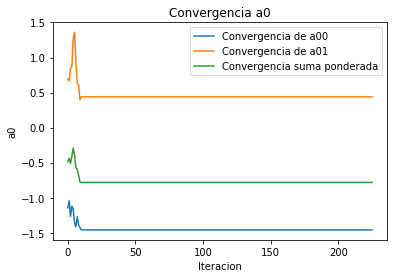

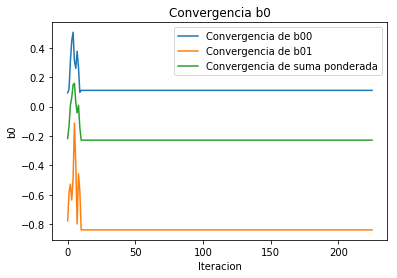

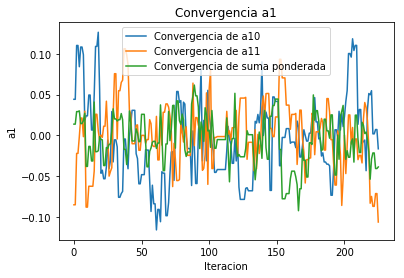

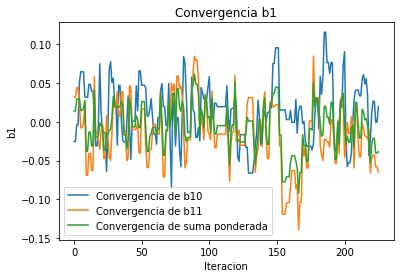

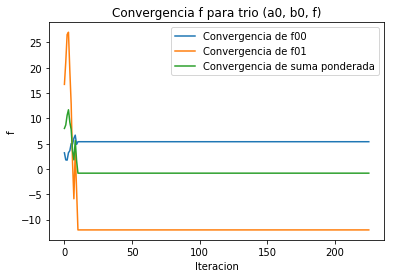

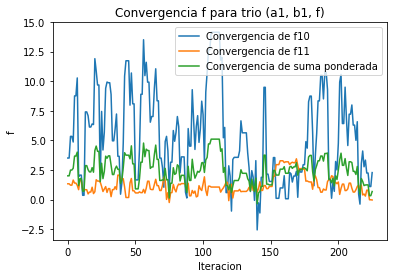

In [9]:
plt.plot(range(largo_1), array_a0[:, 0], label="Convergencia de a00")
plt.plot(range(largo_1), array_a0[:, 1], label="Convergencia de a01")
plt.plot(range(largo_1), array_a0_final, label="Convergencia suma ponderada")
plt.title('Convergencia a0')
plt.xlabel('Iteracion')
plt.ylabel('a0')
plt.legend()
plt.show()

plt.plot(range(largo_1), array_b0[:, 0], label="Convergencia de b00")
plt.plot(range(largo_1), array_b0[:, 1], label="Convergencia de b01")
plt.plot(range(largo_1), array_b0_final, label="Convergencia de suma ponderada")
plt.title('Convergencia b0')
plt.xlabel('Iteracion')
plt.ylabel('b0')
plt.legend()

plt.show()


plt.plot(range(largo_2), array_a1[:, 0], label="Convergencia de a10")
plt.plot(range(largo_2), array_a1[:, 1], label="Convergencia de a11")
plt.plot(range(largo_2), array_b1_final, label="Convergencia de suma ponderada")
plt.title('Convergencia a1')
plt.xlabel('Iteracion')
plt.ylabel('a1')
plt.legend()

plt.show()

plt.plot(range(largo_2), array_b1[:, 0], label="Convergencia de b10")
plt.plot(range(largo_2), array_b1[:, 1], label="Convergencia de b11")
plt.plot(range(largo_2), array_b1_final, label="Convergencia de suma ponderada")
plt.title('Convergencia b1')
plt.xlabel('Iteracion')
plt.ylabel('b1')
plt.legend()

plt.show()

plt.plot(range(largo_1), array_f0[:, 0], label="Convergencia de f00")
plt.plot(range(largo_1), array_f0[:, 1], label="Convergencia de f01")
plt.plot(range(largo_1), array_f0_final, label="Convergencia de suma ponderada")

plt.title('Convergencia f para trio (a0, b0, f)')
plt.xlabel('Iteracion')
plt.ylabel('f')
plt.legend()

plt.show()

plt.plot(range(largo_2), array_f1[:, 0], label="Convergencia de f10")
plt.plot(range(largo_2), array_f1[:, 1], label="Convergencia de f11")
plt.plot(range(largo_2), array_f1_final, label="Convergencia de suma ponderada")

plt.title('Convergencia f para trio (a1, b1, f)')
plt.xlabel('Iteracion')
plt.ylabel('f')
plt.legend()

plt.show()





### Comentarios convergencia

Hay varios casos en que se puede ver que despues de varias muestras, deja de aceptar y se queda pegada en una. Tambien pasa en que para algunos parametros queda oscilando entre varios valores, es cosa de dejar corriendo mas tiempo para ver si se alcanza algo mas estacionario.

Tambien se puede ver que f en algunos casos toma valores negativos. Decidi dejar esto asi y manejarlo despues, ya que si rechazaba todas esas muestras me iban a quedar muy pocas.


## Gibbs sampling

Primero me voy a quedar con parametros fijos para las distribuciones sacados de metropolis


Como en total tenemos 4 distribuciones normales, los parametros de cada una se definen a continuacion y son

### Primera mezcla

$$N(mean=[a_{00}\_final, b_{00}\_final, f_{00}\_final], cov = cov_1)*\pi_1 + N(mean=[a_{01}\_final, b_{01}\_final, f_{01}\_final], cov = cov_2)*\pi_2$$

### Segunda mezcla

$$N(mean=[a_{10}\_final, b_{10}\_final, f_{10}\_final], cov = cov_3)*\pi_3 + N(mean=[a_{11}\_final, b_{11}\_final, f_{11}\_final], cov = cov_4)*\pi_4$$

In [10]:
a00_final = np.mean(array_a0[:, 0])
a01_final = np.mean(array_a0[:, 1])

b00_final = np.mean(array_b0[:, 0])
b01_final = np.mean(array_b0[:, 1])

a10_final = np.mean(array_a1[:, 0])
a11_final = np.mean(array_a1[:, 1])

b10_final = np.mean(array_b1[:, 0])
b11_final = np.mean(array_b1[:, 1])

f00_final = np.mean(array_f0[:, 0]) 
f01_final = np.mean(array_f0[:, 1]) 

f10_final = np.mean(array_f1[:, 0]) 
f11_final = np.mean(array_f1[:, 1]) 



# Estos son los valores que usare para la distribucion final
means = {
    'a0': [a00_final, a01_final],
    'a1': [a10_final, a11_final],
    'b0': [b00_final, b01_final],
    'b1': [b10_final, b11_final],
    'f0': [f00_final, f01_final],
    'f1': [f10_final, f11_final],
}

means


{'a0': [-1.4507775322129468, 0.45640108975590293],
 'a1': [-0.0045312467879747645, 0.0009770096242260864],
 'b0': [0.11755559651529084, -0.8247192452518217],
 'b1': [0.012533045441923915, -0.013922127380675203],
 'f0': [5.3366403433195035, -10.969654379911454],
 'f1': [5.347590311443316, 1.2041628728320344]}

### Descripcion metodo

La idea es hacer lo mismo para el trio (a0, b0, f) y (a1, b1, f)

Como gibbs sampling es iterativo, y va dependiendo de valores anteriores, voy a partir con 2 valors para (b0, f) y (b1, f) (Las mismas medias) y voy a partir desde ahi

Voy a explicar como funciona el metodo, y las distribuciones condicionales de una normal multivariada para un trio de parametros, pero el otro funciona exactamente igual.

Partimos de la base que tenemos las medias y covarianzas de esta distribucion

$$N(mean=[a_{00}\_final, b_{00}\_final, f_{00}\_final], cov = cov_1)*\pi_1 + N(mean=[a_{01}\_final, b_{01}\_final, f_{01}\_final], cov = cov_2)*\pi_2$$

Partimos generando un numero $u  \;\;uniform(0, 1)$, y lo comparamos con los pesos dados. Si es menor que $\pi_1$ usamos solo la condicional de la primera parte, y sino de la segunda.
Supongamos que elegimos la primera gaussiana. Queremos sacar una muestra de la condicional
$$P(a_0|b_0=b_0, f = f)$$

Para esto, podemos usar la formula encontrada [aqui](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions)

Donde ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/221c3f05cf82b6e6c304b80531caee63bcb965ba) 
Son las matrices a usar

y la media de la distribucion que queda es ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/fe1e882ee02d2542a04ccbb493a8b875dd0dc8d4)
y la matriz de covarianza ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/835c7898b08938036d011c9b0f5526368e256cb8)

Y como estamos condicionando en 2 variables, nos queda una normal de una sola variable.

Cabe notar que cada vez que condicionemos en algun par de variables, hay que tener cuidado al armar las matrices que van quedando. Lo que hago es rotar la matriz de covarianza cada vez, para ocupar las mismas formulas siempre.

In [25]:
def gibbs_sampling(N_muestras, means, params):
    pi_1, pi_2 = params['weights_0']
    cov_1, cov_2 = params['covs_0']
    pi_3, pi_4 = params['weights_1']
    cov_3, cov_4 = params['covs_1']
    
    # Parto sacando de a0, entonces parto con b0 y f0 = medias
    array_a0 = []
    array_b0 = [np.mean(means['b0'])]
    array_f0 = [np.mean(means['f0'])]
    
    # Parto sacando de a1, entonces parto con b1 y f1 = medias
    array_a1 = []
    array_b1 = [np.mean(means['b1'])]
    array_f1 = [np.mean(means['f1'])]

    
    for _ in range(N_muestras):
        # Primero elijo cual de las 2 distribuciones usar
        u = np.random.random()
        
        if u <= pi_1:
            # Elijo gauss 1
            cov_usar = cov_1
            mean_a0 = means['a0'][0]
            mean_b0 = means['b0'][0]
            mean_f0 = means['f0'][0]
        else:
            # Elijo gauss 2
            cov_usar = cov_2
            mean_a0 = means['a0'][1]
            mean_b0 = means['b0'][1]
            mean_f0 = means['f0'][1]
        
        # Roto la matriz para la condicional que quiera
        # Ahora es [a0, b0, f] - [a0, b0, f]
        # Condicionada en b0 y f queda
        # [b0, f, a0] - [b0, f, a0]
        
        s11 = cov_usar[[[0]], [0]] # 1x1
        s12 = cov_usar[[[0]], [1, 2]] # 1x2
        s21 = cov_usar[[[1], [2]], [0]] # 2x1
        s22 = cov_usar[[[1], [2]], [1, 2]] # 2x2
        
        media = np.array(mean_a0) + s12*(np.matrix(s22).I)*(np.matrix([array_b0[-1], array_f0[-1]]) - np.array([mean_b0, mean_f0])).T
        sigma = s11 - s12*(np.matrix(s22).I)*s21
        
        # Saco la muestra para a0
        array_a0.append(multivariate_normal.rvs(mean = media, cov=sigma))
        
        u = np.random.random()
        
        if u <= pi_1:
            # Elijo gauss 1
            cov_usar = cov_1
            mean_a0 = means['a0'][0]
            mean_b0 = means['b0'][0]
            mean_f0 = means['f0'][0]
        else:
            # Elijo gauss 2
            cov_usar = cov_2
            mean_a0 = means['a0'][1]
            mean_b0 = means['b0'][1]
            mean_f0 = means['f0'][1]
        
        
        
        # Ahora b0 --> Lo mismo, pero roto la matriz para que b0 quede arriba izquierda
        cov_usar = np.roll(cov_usar, -1,  axis=0)
        cov_usar = np.roll(cov_usar, -1,  axis=1)
        
        s11 = cov_usar[[[0]], [0]] # 1x1
        s12 = cov_usar[[[0]], [1, 2]] # 1x2
        s21 = cov_usar[[[1], [2]], [0]] # 2x1
        s22 = cov_usar[[[1], [2]], [1, 2]] # 2x2
        
        media = np.array(mean_b0) + s12*(np.matrix(s22).I)*(np.matrix([array_f0[-1], array_a0[-1]]) - np.array([mean_f0, mean_a0])).T
        sigma = s11 - s12*(np.matrix(s22).I)*s21
        
        # Saco la muestra para b0
        array_b0.append(multivariate_normal.rvs(mean = media, cov=sigma))
        
        # Ahora f--> exactamente lo mismo
        
        u = np.random.random()
        
        if u <= pi_1:
            # Elijo gauss 1
            cov_usar = cov_1
            mean_a0 = means['a0'][0]
            mean_b0 = means['b0'][0]
            mean_f0 = means['f0'][0]
        else:
            # Elijo gauss 2
            cov_usar = cov_2
            mean_a0 = means['a0'][1]
            mean_b0 = means['b0'][1]
            mean_f0 = means['f0'][1]
            
        cov_usar = np.roll(cov_usar, -1,  axis=0)
        cov_usar = np.roll(cov_usar, -1,  axis=1)
        
        s11 = cov_usar[[[0]], [0]] # 1x1
        s12 = cov_usar[[[0]], [1, 2]] # 1x2
        s21 = cov_usar[[[1], [2]], [0]] # 2x1
        s22 = cov_usar[[[1], [2]], [1, 2]] # 2x2
        
        media = np.array(mean_f0) + s12*(np.matrix(s22).I)*(np.matrix([array_a0[-1], array_b0[-1]]) - np.array([mean_a0, mean_b0])).T
        sigma = s11 - s12*(np.matrix(s22).I)*s21
        
        # Saco la muestra para f0
        array_f0.append(multivariate_normal.rvs(mean = media, cov=sigma))
        
        
        
        
        
        ##################### Ahora para a1, b1, f1
        
        # Primero elijo cual de las 2 distribuciones usar
        u = np.random.random()
        
        if u <= pi_3:
            # Elijo gauss 3
            cov_usar = cov_3
            mean_a1 = means['a1'][0]
            mean_b1 = means['b1'][0]
            mean_f1 = means['f1'][0]
        else:
            # Elijo gauss 4
            cov_usar = cov_4
            mean_a1 = means['a1'][1]
            mean_b1 = means['b1'][1]
            mean_f1 = means['f1'][1]
        
        
        s11 = cov_usar[[[0]], [0]] # 1x1
        s12 = cov_usar[[[0]], [1, 2]] # 1x2
        s21 = cov_usar[[[1], [2]], [0]] # 2x1
        s22 = cov_usar[[[1], [2]], [1, 2]] # 2x2
        
        media = np.array(mean_a1) + s12*(np.matrix(s22).I)*(np.matrix([array_b1[-1], array_f1[-1]]) - np.array([mean_b1, mean_f1])).T
        sigma = s11 - s12*(np.matrix(s22).I)*s21
        
        # Saco la muestra para a0
        array_a1.append(multivariate_normal.rvs(mean = media, cov=sigma))
        
        
        
        
        
        # Ahora b1 --> Lo mismo, pero roto la matriz para que b1 quede arriba izquierda
        
        if u <= pi_3:
            # Elijo gauss 3
            cov_usar = cov_3
            mean_a1 = means['a1'][0]
            mean_b1 = means['b1'][0]
            mean_f1 = means['f1'][0]
        else:
            # Elijo gauss 4
            cov_usar = cov_4
            mean_a1 = means['a1'][1]
            mean_b1 = means['b1'][1]
            mean_f1 = means['f1'][1]
        cov_usar = np.roll(cov_usar, -1,  axis=0)
        cov_usar = np.roll(cov_usar, -1,  axis=1)
        
        s11 = cov_usar[[[0]], [0]] # 1x1
        s12 = cov_usar[[[0]], [1, 2]] # 1x2
        s21 = cov_usar[[[1], [2]], [0]] # 2x1
        s22 = cov_usar[[[1], [2]], [1, 2]] # 2x2
        
        media = np.array(mean_b1) + s12*(np.matrix(s22).I)*(np.matrix([array_f1[-1], array_a1[-1]]) - np.array([mean_f1, mean_a1])).T
        sigma = s11 - s12*(np.matrix(s22).I)*s21
        
        # Saco la muestra para b1
        array_b1.append(multivariate_normal.rvs(mean = media, cov=sigma))
        
        # Ahora f--> exactamente lo mismo
        
        if u <= pi_3:
            # Elijo gauss 3
            cov_usar = cov_3
            mean_a1 = means['a1'][0]
            mean_b1 = means['b1'][0]
            mean_f1 = means['f1'][0]
        else:
            # Elijo gauss 4
            cov_usar = cov_4
            mean_a1 = means['a1'][1]
            mean_b1 = means['b1'][1]
            mean_f1 = means['f1'][1]
        cov_usar = np.roll(cov_usar, -1,  axis=0)
        cov_usar = np.roll(cov_usar, -1,  axis=1)
        
        s11 = cov_usar[[[0]], [0]] # 1x1
        s12 = cov_usar[[[0]], [1, 2]] # 1x2
        s21 = cov_usar[[[1], [2]], [0]] # 2x1
        s22 = cov_usar[[[1], [2]], [1, 2]] # 2x2
        
        media = np.array(mean_f1) + s12*(np.matrix(s22).I)*(np.matrix([array_a1[-1], array_b1[-1]]) - np.array([mean_a1, mean_b1])).T
        sigma = s11 - s12*(np.matrix(s22).I)*s21
        
        # Saco la muestra para f0
        array_f1.append(multivariate_normal.rvs(mean = media, cov=sigma))

    # Me voy a quedar con las ultimas 5 muestras
    
    return list(zip(array_a0[-5:], array_b0[-5:], array_a1[-5:], array_b1[-5:], array_f0[-5:], array_f1[-5:]))
                    
        
        
        

In [29]:
samples = gibbs_sampling(500, means, params)


In [30]:
def original(t, a0, a1, b0, b1, f):
    ret = 0
    prim = a0*np.sin(2*np.pi*(0 + 1)*f*t) + b0*np.cos(2*np.pi*(0 + 1)*f*t)
    seg = a1*np.sin(2*np.pi*(1 + 1)*f*t) + b1*np.cos(2*np.pi*(1 + 1)*f*t)
    return prim + seg


def get_samples(N_samples, a0, a1, b0, b1, f):
#     uniform_sampling = np.random.random(N_samples)*(5)
    uniform_sampling = np.linspace(0, 2, N_samples)
    a = original(uniform_sampling, a0, a1, b0, b1, f)
    return uniform_sampling, a

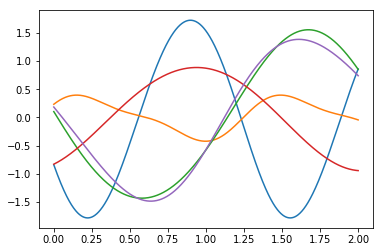

In [31]:
for a0, b0 , a1, b1, f0, f1 in samples:
    x, y = get_samples(1000, a0, a1, b0, b1, 0.14*(f0+f1)/2)
    plt.plot(x, y)

## Comentarios

Viendo las series de tiempo generadas (o corriendo varias veces el metodo de gibbs sampling), podemos ver que se obtienen muchas series muy distintas. A pesar de que esto se pueda deber debido a errores en el codigo, o en el metodo, puede ser que al usar un metodo de muestreo aleatorio, nos den series de tiempos muy distintas. Si se va a usar esto para algo serio, habria que tener mucho cuidado, ya se estaria haciendo casoa muestras no representativas de la realidad.  

Si es que se separaran bien los datos observados en la practica, y se categorizaran en distintas categorias de series de tiempos, si se podrian generar series de acuerdo a su aparicion en la naturaleza, y con menos varianza que la observada en esta tarea, donde se utilizaron todos los tipos existentes.

Por ejemplo, si se sabe que hay una serie poco frecuente pero que si aparece en la naturaleza, y se quiere entrenar algun modelo de inteligencia artificial que lo incluya, se necesitan varios ejemplos de este. Si es poco frecuente, hay que buscar una forma de darle al modelo mas ejemplos de esta serie, y de una mejor manera que simplemente duplicando los datos. Para esto, el metodo estudiado podria ser util, ya que entrega modelos similares, que comparten las mismas caracteristicas, pero no son exactamente iguales. Van a tener un poco de ruido necesario para los metodos.